## Processing initial h5 files

In [1]:
# Importing relevant packages. Sparticles_FCC_notnorm has an edited dataset.py within it.
#Dataset from sparticles_FCC has no normalisation and only has the low level features in USEFUL_COLS

from sparticles import EventsDataset

from sparticles import DEFAULT_EVENT_SUBSETS

import matplotlib.pyplot as plt

from sparticles.transforms import MakeHomogeneous
make_homogeneous_trans = MakeHomogeneous()

from sparticles import plot_event_2d

import os

import errno

import numpy as np

from numpy import pi

In [10]:


#Code block for processing the raw data from the h5 file. These are the h5 files that cut events with pT < 20GeV.
sig_no = 21800
sgt_no = 21800
ttb_no = 0
sig_last = sig_no - 1
sgt_last = (sgt_no + sig_no) - 1

useful_cols = USEFUL_COLS = [
             # tau
            'pTt1',
            'etat1',
            'phit1',
             # # lepton            
            'pTl1',
            'etal1',
            'phil1',
             # b1 
            'pTb1',
            'etab1',
            'phib1',
            #b2
            'pTb2',
            'etab2',
            'phib2',
             # energy
            'ETMiss',
            'nan',
            'ETMissPhi',
             # jet 3
            'pTj1',
            'etaj1',
            'phij1',
]



dataset = EventsDataset(
    root= f'/hepstore/{os.environ["USER"]}/fcc_hh_data',
    url='https://cernbox.cern.ch/s/8Oh5dfiB9K3qHnl/download',
    delete_raw_archive=False,
    add_edge_index=True,
    event_subsets={'signal': sig_no, 'singletop': sgt_no, 'ttbar': ttb_no}, #For the FCC, only ttbar events are used, but the h5 file for background is saved and taken from the 'singletop' file. 
#    transform=MakeHomogeneous(),
    download_type=2,
    signal_filename='FCChh_lephad.h5', # Specify the signal filename here
    useful_cols=useful_cols
)

This may take a while...
Extracting files...
Moving files...
Moved /hepstore/gwilliam/fcc_hh_data/raw/8Oh5dfiB9K3qHnl/signal to /hepstore/gwilliam/fcc_hh_data/raw
Moved /hepstore/gwilliam/fcc_hh_data/raw/8Oh5dfiB9K3qHnl/singletop to /hepstore/gwilliam/fcc_hh_data/raw
Moved /hepstore/gwilliam/fcc_hh_data/raw/8Oh5dfiB9K3qHnl/ttbar to /hepstore/gwilliam/fcc_hh_data/raw
Cleaning up...


Processing...
Processing events in /hepstore/gwilliam/fcc_hh_data/raw/signal/FCChh_lephad.h5: 100%|███████████████| 21800/21800 [00:02<00:00, 7526.54it/s]
Processing events in /hepstore/gwilliam/fcc_hh_data/raw/signal/FCChh_lephad.h5: 100%|███████████████| 21800/21800 [00:02<00:00, 7544.26it/s]
Processing events in /hepstore/gwilliam/fcc_hh_data/raw/singletop/FCChh_lephad.h5: 100%|████████████| 21800/21800 [00:02<00:00, 7952.45it/s]
Processing events in /hepstore/gwilliam/fcc_hh_data/raw/signal/FCChh_lephad.h5: 100%|███████████████| 21800/21800 [00:02<00:00, 8064.76it/s]
Processing events in /hepstore/gwilliam/fcc_hh_data/raw/singletop/FCChh_lephad.h5: 100%|████████████| 21800/21800 [00:02<00:00, 7406.32it/s]
Processing events in /hepstore/gwilliam/fcc_hh_data/raw/ttbar/FCChh_tt012j.h5: 0it [00:00, ?it/s]
Done!


## Relevant Classes

In [3]:
#Defining the object numbers in each event.

tau = 0
l1 = 1
b1 = 2
b2 = 3
energy = 4
jet = 5

pT = 0
eta = 1
phi = 2

#function for creating lists of specific features of specific objects, split into signal. single-top and tt-bar.
#This can be done this way because all the signal events are processed first, then single top then tt-bar.
def obj_ft(obj,ft):

    sig_obj_ft = []
    sgt_obj_ft = []
    ttb_obj_ft = []

    for i in range(len(dataset)):

        if dataset[i].x.shape == (5,3) and obj == 5: #makes it so that final object (jet) is skipped for graphs without an extra jet.
            continue
        
        elif dataset[i].y.item() == 1: #and dataset[i].x.shape == (6,3):  
            sig_obj_ft.append(dataset[i].x[obj,ft].item())

        elif dataset[i].y.item() == 0 and  i > sig_last and i < (sgt_last + 1):# and dataset[i].x.shape == (6,3):
            sgt_obj_ft.append(dataset[i].x[obj,ft].item())

        elif dataset[i].y.item() == 0 and  i > sgt_last:# and dataset[i].x.shape == (6,3):
            ttb_obj_ft.append(dataset[i].x[obj,ft].item())
    
    return sig_obj_ft, sgt_obj_ft, ttb_obj_ft,

#notation here suggests singletop data is being used but for the FCC the background is ttbar data.

In [4]:
#class with functions for calculating complex features other than centrality MET.
import vector
class Higher_order:
    def __init__(self, pt1, pt2, eta1, eta2, phi1, phi2):
        self.pt1 = pt1
        self.pt2 = pt2
        self.eta1 = eta1
        self.eta2 = eta2
        self.phi1 = phi1
        self.phi2 = phi2

        self.b1 = vector.obj(pt=self.pt1, phi=self.phi1, eta=self.eta1, mass=0)
        self.b2 = vector.obj(pt=self.pt2, phi=self.phi2, eta=self.eta2, mass=0)
        self.hbb = self.b1 + self.b2

    def dEta(self):
        return abs(self.b1.deltaeta(self.b2))

    def dPhi(self):
        return self.b1.deltaphi(self.b2)
            
    def dR(self):
        return self.b1.deltaR(self.b2)
        
    def inv_M(self):
        return self.hbb.mass

#x is only for lepton, tau and l1 but we include it here without those specified to make life easier.
    # def x(def x(phi_met, phi_l1, phi_l2):
    #     x = np.sin(phi_met - phi_l1) / np.sin(phi_l2 - phi_l1)
    #     return x
    def dpT(self):
        return self.pt1 - self.pt2

    def m_T(self):
        b1_T = vector.obj(pt = self.b1.pt, eta = 0, phi= self.b1.phi, mass = 0)
        b2_T = vector.obj(pt = self.b2.pt, eta = 0, phi= self.b2.phi, mass = 0)
        return (b1_T+b2_T).mass


In [5]:
# function for calculating complex features between two objects for each event for signal and background.
def obj_cpxft(obj1, obj2):

    sig_dEta_objects = []
    sig_dPhi_objects = []
    sig_dR_objects = []
    sig_invM_objects = []
    sig_dpT_objects = []
    sig_mTW_objects = []

    bkg_dEta_objects = []
    bkg_dPhi_objects = []
    bkg_dR_objects = []
    bkg_invM_objects = []
    bkg_dpT_objects = []
    bkg_mTW_objects = []
    
    for i in range (len(dataset)):

        if i < sig_no:

            pt1 = dataset[i].x[obj1,pT].item()
            pt2 = dataset[i].x[obj2,pT].item()
            eta1 = dataset[i].x[obj1,eta].item()
            eta2 = dataset[i].x[obj2,eta].item()
            phi1 = dataset[i].x[obj1,phi].item()
            phi2 = dataset[i].x[obj2,phi].item()
        
            higher_order = Higher_order(pt1,pt2,eta1,eta2,phi1,phi2)

            sig_dEta_objects.append(higher_order.dEta())
            sig_dPhi_objects.append(higher_order.dPhi())
            sig_dR_objects.append(higher_order.dR())
            sig_invM_objects.append(higher_order.inv_M())
            sig_dpT_objects.append(higher_order.dpT())
            sig_mTW_objects.append(higher_order.m_T())

        elif i > (sig_no-1)  and i < (sgt_last + 1):

            pt1 = dataset[i].x[obj1,pT].item()
            pt2 = dataset[i].x[obj2,pT].item()
            eta1 = dataset[i].x[obj1,eta].item()
            eta2 = dataset[i].x[obj2,eta].item()
            phi1 = dataset[i].x[obj1,phi].item()
            phi2 = dataset[i].x[obj2,phi].item()
        
            higher_order = Higher_order(pt1,pt2,eta1,eta2,phi1,phi2)

            bkg_dEta_objects.append(higher_order.dEta())
            bkg_dPhi_objects.append(higher_order.dPhi())
            bkg_dR_objects.append(higher_order.dR())
            bkg_invM_objects.append(higher_order.inv_M())
            bkg_dpT_objects.append(higher_order.dpT())
            bkg_mTW_objects.append(higher_order.m_T())
                        
    return sig_dEta_objects, sig_dPhi_objects, sig_dR_objects, sig_invM_objects, sig_dpT_objects, sig_mTW_objects, bkg_dEta_objects, bkg_dPhi_objects, bkg_dR_objects, bkg_invM_objects, bkg_dpT_objects, bkg_mTW_objects

### Checking distributions

In [6]:
#Applying function to the two b-jets to compute more complex variables
sig_dEta_bb, sig_dPhi_bb, sig_dR_bb, sig_invM_bb, sig_dpT_bb, sig_mTW_bb, bkg_dEta_bb, bkg_dPhi_bb, bkg_dR_bb, bkg_invM_bb, bkg_dpT_bb, bkg_mTW_bb = obj_cpxft(b1,b2)


length of signal invariant masses: 21800
First signal value for invariant mass 118.67097173812851

length of background invariant masses: 21800
First background value for invariant mass 86.86465171461147



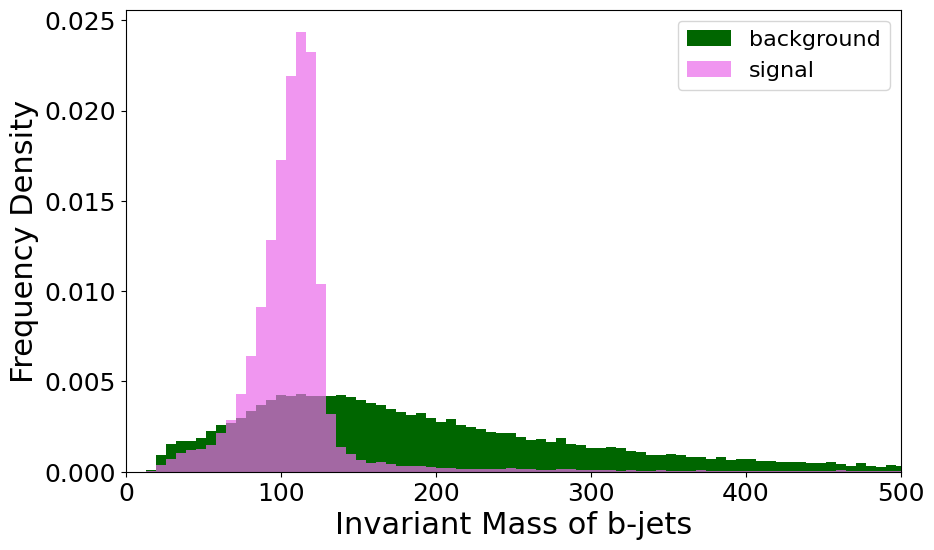

In [7]:
# plot the mass of the hbb system

#invM_bb.append(higher_order_bb.inv_M())
import matplotlib.pyplot as plt


print('length of signal invariant masses:',len(sig_invM_bb))
print('First signal value for invariant mass',sig_invM_bb[0])
print('')
print('length of background invariant masses:',len(bkg_invM_bb))
print('First background value for invariant mass',bkg_invM_bb[0])
print('')

#Now we can plot all the values we need baso:

LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.figure(figsize=(10, 6))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

#a=ttb_tau_pt #a uniform distribution
b=bkg_invM_bb #a normal distribution
c=sig_invM_bb

bins=np.histogram(np.hstack((b,c)), bins=(50*15))[1] #get the bin edges
#plt.hist(a, bins,color='#93f393',alpha = 1,label= r'$t \bar{t}$',density = True)
plt.hist(b, bins,color='#006600',alpha = 1,label='background',density = True)
plt.hist(c, bins,color='#ea6aea',alpha = 0.7,label='signal',density = True)
#plt.title('Distribution of invariant mass of b-jets')
plt.xlim(0, 500)
plt.xlabel('Invariant Mass of b-jets')
plt.ylabel('Frequency Density')
plt.legend()
plt.savefig('FCC Inv mass b-jets')
plt.show()

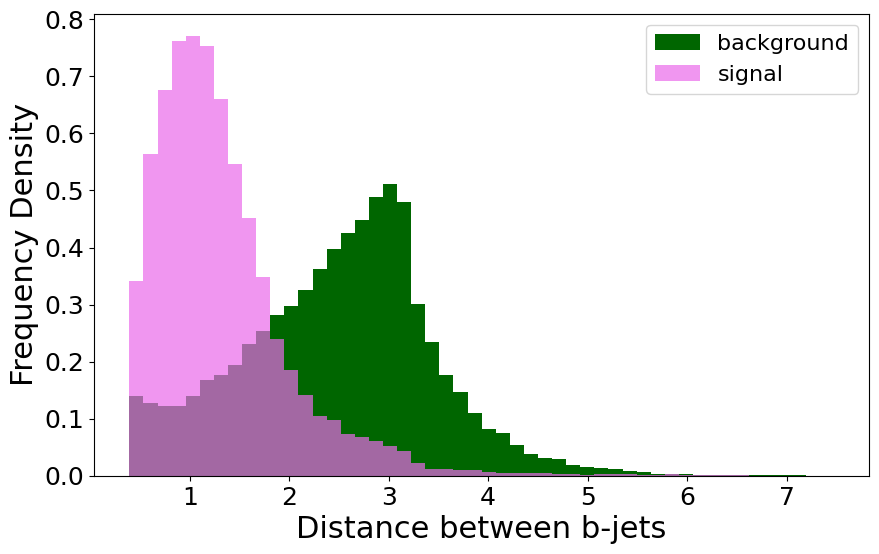

In [8]:
# plot the dRR of the jets 

LEGEND_SIZE = 16
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.figure(figsize=(10, 6))

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

#a=ttb_tau_pt #a uniform distribution
b=bkg_dR_bb #a normal distribution
c=sig_dR_bb

bins=np.histogram(np.hstack((b,c)), bins=50)[1] #get the bin edges
#plt.hist(a, bins,color='#93f393',alpha = 1,label= r'$t \bar{t}$',density = True)
plt.hist(b, bins,color='#006600',alpha = 1,label='background',density = True)
plt.hist(c, bins,color='#ea6aea',alpha = 0.7,label='signal',density = True)
#plt.title('Distribution of invariant mass of b-jets')
plt.xlabel('Distance between b-jets')
plt.ylabel('Frequency Density')
plt.legend()
plt.savefig('FCC dR b-jets')
plt.show()